In [2]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from __future__ import division
from sklearn.cluster import KMeans

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

df_data = pd.read_csv('WA_Fn_UseC_Telco_Customer_Churn.csv')
df_data.info()
df_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


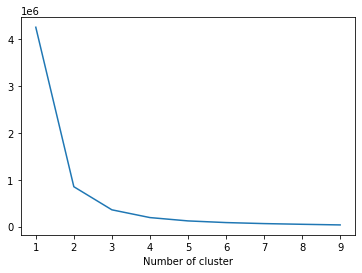

In [8]:
df_data.loc[df_data.Churn=='No','Churn'] = 0
df_data.loc[df_data.Churn=='Yes','Churn'] = 1
df_data['Churn'] = df_data['Churn'].astype(int)
# x = df_data.loc[(df_data.Churn!=0) & (df_data.Churn!=1)]

df_plot = df_data.groupby('gender').Churn.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['gender'],
        y=df_plot['Churn'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

df_data.groupby('gender').Churn.mean()

# Tenure
df_plot = df_data.groupby('tenure').Churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['tenure'],
        y=df_plot['Churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Tenure"},
        title='Tenure based Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Feature Engineering: Creating Tenure groups (K-Means clustering)
sse = {}
df_data_tenure = df_data[['tenure']]
class SupressSettingWithCopyWarning:
    def __enter__(self):
        pd.options.mode.chained_assignment = None

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = 'warn'

with SupressSettingWithCopyWarning():
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_data_tenure)
        df_data_tenure["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()

#build 3 clusters for tenure and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

df_data.groupby('TenureCluster').tenure.describe()

#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns
for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column])
        else:
            dummy_columns.append(column)
#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)


[14:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.87
Accuracy of XGB classifier on test set: 0.81
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       267
           1       0.62      0.59      0.61        86

    accuracy                           0.81       353
   macro avg       0.75      0.74      0.74       353
weighted avg       0.81      0.81      0.81       353



,customerID,proba
0,7590-VHVEG,0.394093
1,5575-GNVDE,0.007522
2,3668-QPYBK,0.261512
3,7795-CFOCW,0.017200
4,9237-HQITU,0.728315


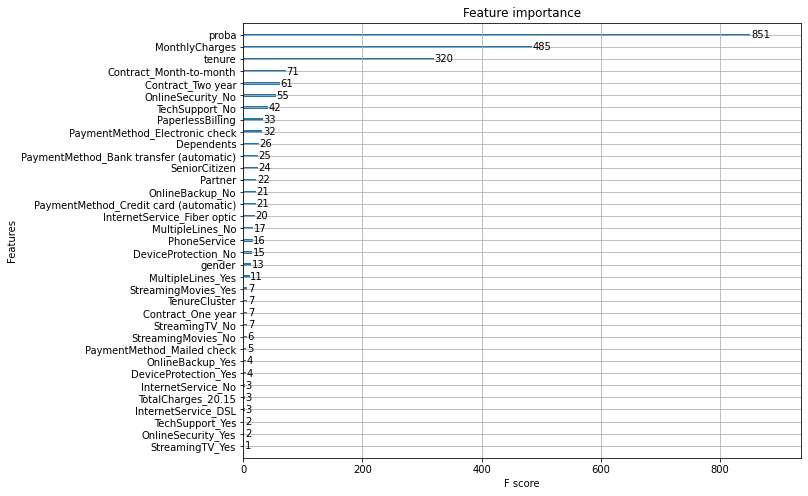

In [7]:
# Binary Classification Model with XGBoost
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1, use_label_encoder=False).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]
df_data[['customerID','proba']].head()